In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from gaia_spec import *
import glob

In [2]:
bps = lsst_filters()
bps.update(stubb_fitlers())

In [3]:
rf = glob.glob('*response*00.npz')
responses = []
teffs = []
for filename in rf:
    responses.append(gaia_response(restore_file=filename))
    teffs.append(filename.replace('.npz', '').split('_')[-1])
# response = gaia_response(restore_file='gaia_response_nonoise.npz')

(0, 5e-16)

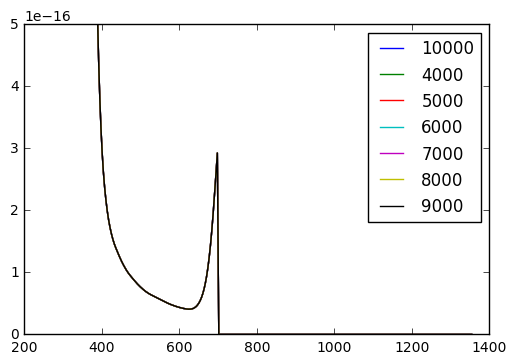

In [4]:
dir(responses[0])
for response,teff in zip(responses, teffs):
    plt.plot(response.blue_wavelen, response.blue_response, label='%s' % teff)
plt.legend()
plt.ylim([0,5e-16])

In [5]:
responses[0].red_response-responses[4].red_response

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [6]:
input_mag = 18
sed = Sed()
# Read in an SED that's solar-like, set to g=16, don't bother adding dust.
sed, pd = read_close_Kurucz(15000., 0., 4.4)# read_close_Kuruz(15000., 0., 4.4)
fNorm = sed.calcFluxNorm(input_mag, bps['g'])
sed.multiplyFluxNorm(fNorm)


Opening cache of LSST SEDs in:
/Users/yoachim/gitRepos/sims_photutils/cacheDir/lsst_sed_cache_2.p


/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:1493: UserWarning: Multiple close files
  warnings.warn('Multiple close files')


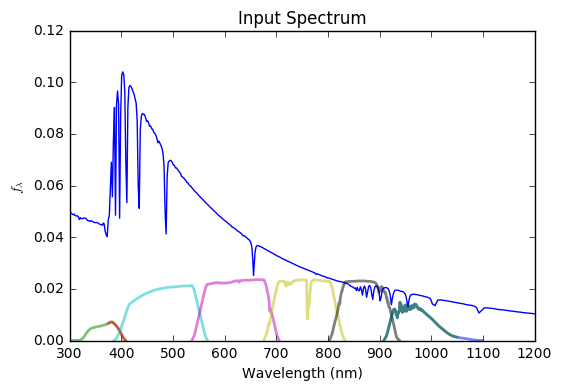

In [7]:
y = sed.flambda*5.03e8*sed.wavelen*100
plt.plot(sed.wavelen, y)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$f_\lambda$ ')
plt.xlim([300,1200])
plt.title('Input Spectrum')

filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    plt.plot(bps[fn].wavelen, bps[fn].sb*y.max()*.5, alpha=.5, linewidth=2)

plt.savefig('Plots/example_input_spec.png')

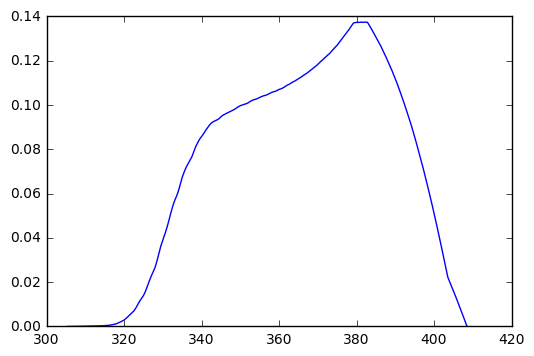

In [8]:
plt.plot(bps['u'].wavelen, bps['u'].sb)

In [9]:
workdir = 'plot_work'
gaia_observed = SED2GAIA(sed, workdir=workdir)


In [10]:
observed_sed = ulysses2SED(data=gaia_observed, response=response)
not_nan = ~np.isnan(observed_sed.flambda)
observed_sed.flambda = np.interp(observed_sed.wavelen, observed_sed.wavelen[not_nan],
                                             observed_sed.flambda[not_nan])

/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:746: UserWarning: There is an area of non-overlap between desired wavelength range  (306.64 to 1238.64)and sed FromArray (581.50 to 1238.17)
  + 'and sed %s (%.2f to %.2f)' % (self.name, wavelen.min(), wavelen.max()))
gaia_spec.py:174: RuntimeWarning: invalid value encountered in divide
  flambda = (red_sed.flambda*red_weight + blue_sed.flambda*blue_weight) / (red_weight + blue_weight)


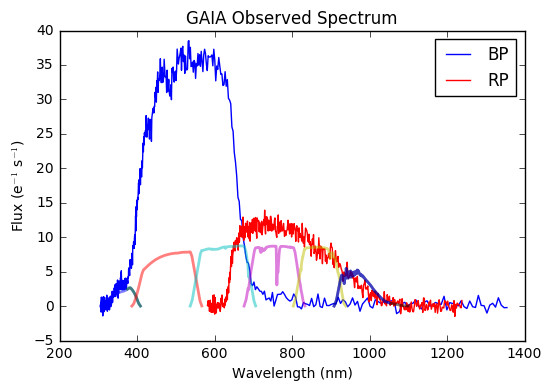

In [11]:
plt.plot(gaia_observed['BP_wave'], gaia_observed['noisySpec'][0]['BPNoisySpec'], 'b', label='BP')
plt.plot(gaia_observed['RP_wave'], gaia_observed['noisySpec'][0]['RPNoisySpec'], 'r', label='RP')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Flux (e$^{-1}$ s$^{-1}$)')
plt.title('GAIA Observed Spectrum')
for fn in filters:
    plt.plot(bps[fn].wavelen, bps[fn].sb*gaia_observed['noisySpec'][0]['BPNoisySpec'].max()*.5, alpha=.5, linewidth=2)
 
plt.savefig('Plots/example_output_spec.png')

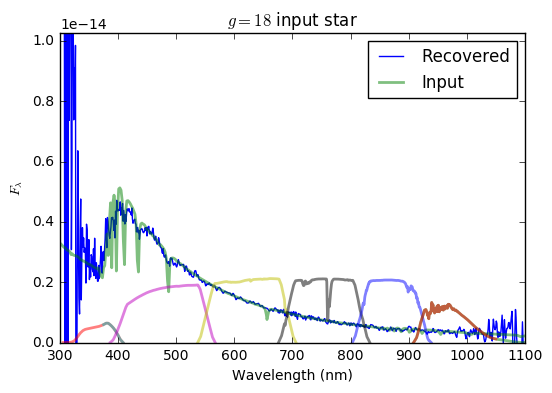

In [12]:
plt.plot(observed_sed.wavelen, observed_sed.flambda, label='Recovered')
plt.plot(sed.wavelen, sed.flambda, label='Input', linewidth=2, alpha=.5)
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$F_\lambda$')
plt.xlim([300,1100])
plt.title(r'$g=%.0f$ input star' % input_mag)
plt.ylim([0,sed.flambda.max()*1.1])
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    plt.plot(bps[fn].wavelen, bps[fn].sb*sed.flambda.max()*.5, alpha=.5, linewidth=2)
    

In [13]:

print 'filter, input, recovered, diff (mmag)'
for fn in filters:
    inmag = sed.calcMag(bps[fn])
    outmag = observed_sed.calcMag(bps[fn])
    print '%s, %.2f, %.2f, %f' % (fn, inmag, outmag, (inmag-outmag)*1e3)

filter, input, recovered, diff (mmag)
u, 18.58, nan, nan
u_truncated, 18.24, 18.20, 42.692401
g, 18.00, 18.00, -2.062270
r, 18.28, 18.27, 6.029177
i, 18.54, 18.53, 2.275199
z, 18.73, 18.73, 1.193958
y, 18.80, 18.78, 15.259165
y_truncated, 18.80, 18.79, 5.838238


/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:746: UserWarning: There is an area of non-overlap between desired wavelength range  (305.40 to 408.50)and sed FromArray (306.64 to 1238.64)
  + 'and sed %s (%.2f to %.2f)' % (self.name, wavelen.min(), wavelen.max()))


In [14]:
def star2mags(teff, feH, logg, response=None, work_dir='temp_work'):
    # Let's see if I can understand the crazy shift with temperature
    filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
    sed, pd = read_close_Kurucz(6000., 0., 4.4)
    fNorm = sed.calcFluxNorm(input_mag, bps['g'])
    sed.multiplyFluxNorm(fNorm)
    gaia_observed = SED2GAIA(sed, workdir=workdir)
    observed_sed = ulysses2SED(data=gaia_observed, response=response)
    not_nan = ~np.isnan(observed_sed.flambda)
    observed_sed.flambda = np.interp(observed_sed.wavelen, observed_sed.wavelen[not_nan],
                                                 observed_sed.flambda[not_nan])
    inmags = []
    outmags = []
    for fn in filters:
        inmags.append(sed.calcMag(bps[fn]))
        outmags.append(observed_sed.calcMag(bps[fn]))
    return (inmags, outmags)


In [15]:
hotin, hotout = star2mags(10000, 0, 4.4, response=response)
coldin, coldout = star2mags(1000, 0, 3., response=response)

In [16]:
hotin, hotout

([19.033972456767835,
  18.595560365701772,
  18.0,
  17.70431707629827,
  17.622193625342682,
  17.60947082993718,
  17.605474906946615,
  17.604910760073331],
 [nan,
  18.548540534347126,
  17.997122613148544,
  17.711706292331129,
  17.623268981160017,
  17.616898073080261,
  17.604796129138641,
  17.602169980594653])